<a href="https://colab.research.google.com/github/Naina-j04/Garbage_classifier/blob/main/Garbage-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
import torch.optim as optim
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#pointing to dataset
data_dir  = '/content/drive/MyDrive/Garbage_classification/Data'

classes = os.listdir(data_dir)
print(classes)

['plastic', 'trash', 'paper', 'glass', 'metal', 'cardboard', 'garbage.pth', 'bettermodel.pth', 'bettermodel2.pth']


In [6]:
#resizing and normalizing the dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

In [7]:
len(dataset)


2527

In [8]:
#splitting the dataset
train_data,val_data,test_data=random_split(dataset,[1616,405,506])
len(train_data),len(val_data),len(test_data)

(1616, 405, 506)

In [9]:
#checking how many images from each class split b/w TVT
train_idx = train_data.indices
val_idx   = val_data.indices
test_idx  = test_data.indices

print("Train class counts:", Counter([dataset.targets[i] for i in train_idx]))
print("Val class counts:", Counter([dataset.targets[i] for i in val_idx]))
print("Test class counts:", Counter([dataset.targets[i] for i in test_idx]))


Train class counts: Counter({3: 380, 1: 306, 4: 304, 2: 278, 0: 259, 5: 89})
Val class counts: Counter({3: 97, 1: 83, 4: 77, 0: 71, 2: 58, 5: 19})
Test class counts: Counter({3: 117, 1: 112, 4: 101, 2: 74, 0: 73, 5: 29})


In [36]:
#class definition
class GarbageCNN(nn.Module):
  def __init__(self,classes=6):
    super (GarbageCNN,self).__init__()
#convulation layers
    self.c1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)
    self.c2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
    self.c3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
    self.c4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
    self.c5=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
#pool layer
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
#fully connected layer
    self.fc = nn.Linear(256 * 8 * 8, classes)
#forward passing - (conv+relu+pool), flattening features, dropout
  def forward(self,x):
    x=self.pool(F.relu(self.c1(x)))
    x=self.pool(F.relu(self.c2(x)))
    x=self.pool(F.relu(self.c3(x)))
    x=self.pool(F.relu(self.c4(x)))
    x=self.pool(F.relu(self.c5(x)))
    x = x.view(x.size(0), -1)
    self.dropout = nn.Dropout(0.5)
    x = self.dropout(x)
    x = self.fc(x)
    return x
garbage=GarbageCNN()


In [37]:
#dataloader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

In [38]:
#defining the training components
classes=6
model=GarbageCNN(classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cuda')

In [39]:
num_epochs = 25
print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

print('Finished Training.')


Starting Training...
Epoch [1/25], Training Loss: 1.7028, Validation Loss: 1.6183, Validation Accuracy: 33.33%
Epoch [2/25], Training Loss: 1.4002, Validation Loss: 1.3745, Validation Accuracy: 40.49%
Epoch [3/25], Training Loss: 1.2850, Validation Loss: 1.3494, Validation Accuracy: 50.86%
Epoch [4/25], Training Loss: 1.1875, Validation Loss: 1.3198, Validation Accuracy: 47.65%
Epoch [5/25], Training Loss: 1.1405, Validation Loss: 1.2911, Validation Accuracy: 50.86%
Epoch [6/25], Training Loss: 1.0645, Validation Loss: 1.2321, Validation Accuracy: 56.05%
Epoch [7/25], Training Loss: 1.0000, Validation Loss: 1.0782, Validation Accuracy: 60.00%
Epoch [8/25], Training Loss: 0.9512, Validation Loss: 1.1957, Validation Accuracy: 61.23%
Epoch [9/25], Training Loss: 0.8662, Validation Loss: 1.1748, Validation Accuracy: 59.51%
Epoch [10/25], Training Loss: 0.8547, Validation Loss: 0.9697, Validation Accuracy: 64.94%
Epoch [11/25], Training Loss: 0.8257, Validation Loss: 1.0404, Validation Accu

In [40]:
# FINAL TEST EVALUATION
print('Starting Final Evaluation on Test Set...')
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f'Final Test Loss: {avg_test_loss:.4f}, Final Test Accuracy: {accuracy:.2f}%')

Starting Final Evaluation on Test Set...
Final Test Loss: 0.7798, Final Test Accuracy: 74.31%


In [41]:
path='/content/drive/MyDrive/Garbage_classification/Data/bettermodel2.pth'
torch.save(model.state_dict(), path)

In [42]:
model = GarbageCNN(classes=6)
path = '/content/drive/MyDrive/Garbage_classification/Data/bettermodel2.pth'
model.load_state_dict(torch.load(path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_image(image_path):
    # Preprocessing prediction images
    transformations = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Loading images
    image = Image.open(image_path).convert('RGB')
    image_tensor = transformations(image).unsqueeze(0).to(device)
    class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
    # Prediction time
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx.item()]
    return predicted_class
# Eg multiple images
image_paths = [
    '/content/drive/MyDrive/Garbage_classification/Data/paper/paper80.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/plastic/plastic12.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/glass/glass99.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/cardboard/cardboard167.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/metal/metal77.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/trash/trash109.jpg',
    '/content/drive/MyDrive/Garbage_classification/Data/trash/trash105.jpg'
]

for img_path in image_paths:
    result = predict_image(img_path)
    print(f"The model predicts the image is: {result}")


The model predicts the image is: paper
The model predicts the image is: plastic
The model predicts the image is: glass
The model predicts the image is: cardboard
The model predicts the image is: metal
The model predicts the image is: paper
The model predicts the image is: metal


In [43]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


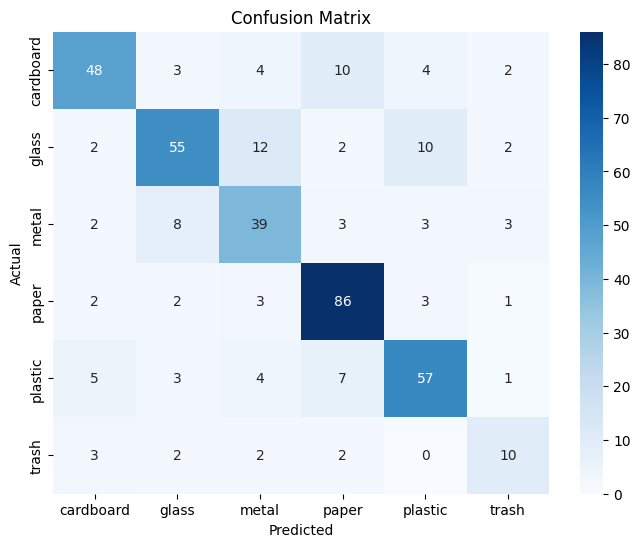

In [44]:
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # ['cardboard','glass','metal','paper','plastic','trash']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


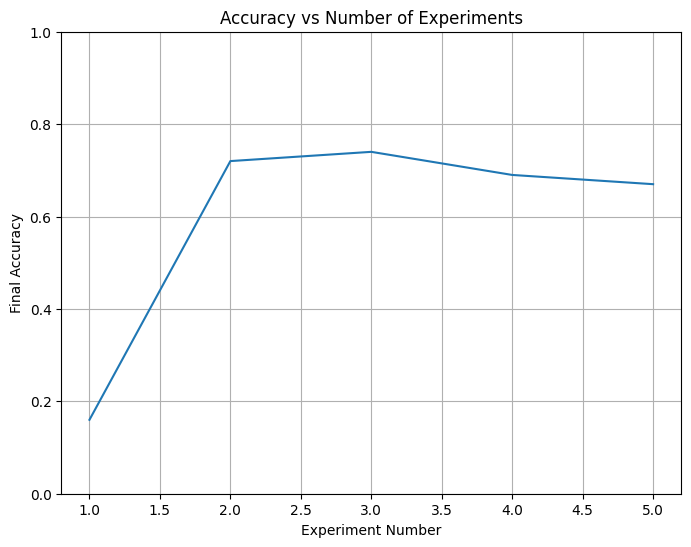

In [5]:
# I ran 5 experiments with different params
experiment_numbers = [1, 2, 3, 4, 5]
final_accuracy = [0.16, 0.72, 0.74, 0.69, 0.67]

plt.figure(figsize=(8,6))
plt.plot(experiment_numbers, final_accuracy,)
plt.title('Accuracy vs Number of Experiments')
plt.xlabel('Experiment Number')
plt.ylabel('Final Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()
